In [ ]:
import pandas as pd
import numpy as np
if not hasattr(np, "product"):
    np.product = np.prod

# Utilicé pgmpy, siendo que busqué en internet y vi que servía
# para construir redes Bayesianas, estimar las probabilidades condicionales y realizar inferencias automáticamente a partir de los datos.
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import networkx as nx
import matplotlib.pyplot as plt

In [28]:
data = pd.read_csv("./wbes_sintetico.csv")
cols = [
    "sales_annual_usd",
    "labor_productivity_usd_per_employee",
    "employees",
    "firm_age_years",
    "training",
    "access_finance",
    "exporter",
    "competition_level",
    "digital_payments",
]

completeData = data[cols]

dataNoNull = completeData.dropna().copy()

dataNoNull.shape
dataNoNull.head()

,sales_annual_usd,labor_productivity_usd_per_employee,employees,firm_age_years,training,access_finance,exporter,competition_level,digital_payments
0,42879.327130,5374.714150,13.0,10.0,1.0,1.0,0,Media,1
1,54570.897174,4728.282631,9.0,6.0,0.0,0.0,0,Baja,1
2,56311.260030,3104.627628,15.0,10.0,0.0,0.0,1,Baja,1
3,93419.359675,3129.017055,25.0,12.0,1.0,0.0,1,Baja,1
4,24608.889361,2824.645056,9.0,9.0,0.0,0.0,0,Baja,0


In [ ]:
mean_sales = dataNoNull["sales_annual_usd"].mean()
dataNoNull["successful"] = (dataNoNull["sales_annual_usd"] > mean_sales).astype(int)

vars_bn = [
    "successful",
    "training",
    "access_finance",
    "exporter",
    "competition_level",
]

bn_data = dataNoNull[vars_bn].copy()

In [30]:
for col in ["successful", "training", "access_finance", "exporter"]:
    bn_data[col] = bn_data[col].astype(int)

bn_data["competition_level"] = bn_data["competition_level"].astype("category")

bn_data.dtypes

successful              int64
training                int64
access_finance          int64
exporter                int64
competition_level    category
dtype: object

In [ ]:
# Aquí definí la estructura del modelo
# Donde al final las flechas representarán relaciones causales entre variables.

model = BayesianNetwork(
    [
        ("access_finance", "training"),
        ("access_finance", "successful"),
        ("training", "successful"),
        ("competition_level", "successful"),
        ("exporter", "successful"),
    ]
)
# Este es el ajuste del modelo para que las probabilidades se calculen automáticamente a partir de los datos.
model.fit(bn_data, estimator=MaximumLikelihoodEstimator)

c:\Users\panch\anaconda3\Lib\site-packages\pgmpy\estimators\base.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)


In [ ]:
# Se utiliza inferencia para calcular probabilidades condicionales dadas ciertas evidencias.
inference = VariableElimination(model)

# Y se hace una consulta de probabilidad de éxito bajo la condición especificada.
query = inference.query(
    variables=["successful"], evidence={"access_finance": 1, "training": 1}
)

print(query)

+---------------+-------------------+
| successful    |   phi(successful) |
+===============+===================+
| successful(0) |            0.3826 |
+---------------+-------------------+
| successful(1) |            0.6174 |
+---------------+-------------------+


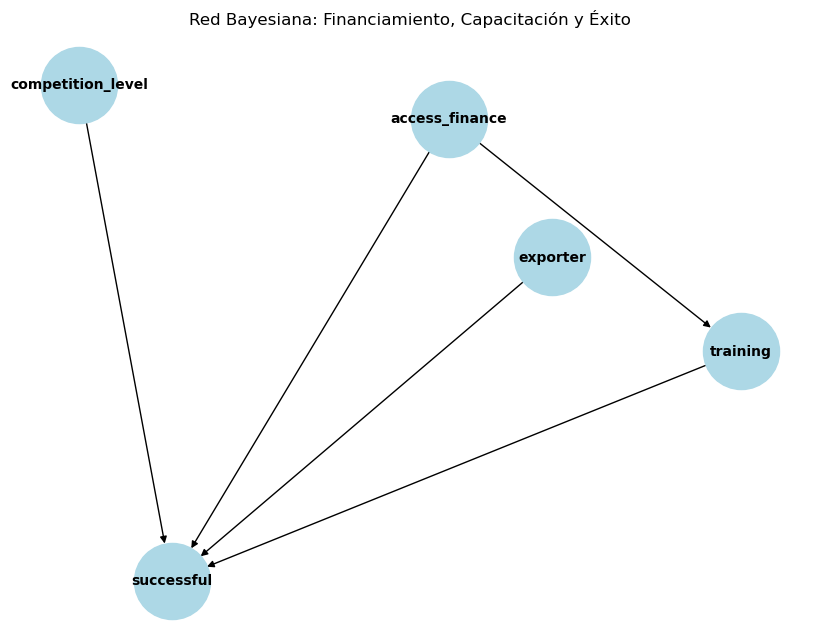

In [33]:
G = nx.DiGraph()
G.add_edges_from(model.edges())

plt.figure(figsize=(8, 6))

pos = nx.spring_layout(G, seed=42)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=3000,
    node_color="lightblue",
    font_size=10,
    font_weight="bold",
    arrows=True,
)

plt.title("Red Bayesiana: Financiamiento, Capacitación y Éxito")
plt.show()

## Análisis y Discusión de Resultados

Con el objetivo de analizar las relaciones causales entre **financiamiento, capacitación y éxito empresarial** tal y como plantea el problema, implementé una **Red Bayesiana** basandome en las variables de la base de datos, tales como **successful, training, access_finance, exporter y competition_level**. La estructura del modelo representa dependencias dirigidas donde el éxito empresarial depende de factores financieros, estratégicos y del entorno competitivo.

La probabilidad marginal obtenida con base a esta metodología fue de **P(successful = 1) = 0.6174**, indicandonos que el 61.7% de las empresas superan el promedio de ventas. Además a partir del grafo creado, podemos observar gracaias a las flechas dirigidas desde **access_finance, training, exporter y competition_level** hacia **successful**, que estas variables son causas directas del éxito empresarial. Además, en el grafo también surgen flechas desde **access_finance** hacia **training y exporter**, lo que implica que el financiamiento puede influir indirectamente en el éxito al afectar primero la capacitación y la condición de empresa exportadora.

En conclusión, podemos observar que el acceso a financiamiento facilita que la empresa invierta y fortalezca sus operaciones, lo que a su vez puede mejorar su desempeño general. De igual manera, la capacitación contribuye a elevar las habilidades del personal, mientras que ser exportadora amplía las oportunidades de venta y diversifica los ingresos. Por otro lado, el nivel de competencia influye en las condiciones del mercado en el que la empresa se desarrolla. En conjunto, estos factores muestran que el éxito empresarial depende de la interacción entre recursos financieros, capacidades internas y el entorno competitivo.